# Page Rotation and Skew Detection

When pages are scanned, they often are scanned at different orientations. 

Two common kinds of rotations:

- rotations by multiples of 90 degrees
- rotations by small angles relative to the pixel coordinate system ("skew")

# Overview

- page rotation and skew correction "boring" but crucial
- examples of designing simple DL models for document analysis
- examples of dlinputs input pipelines
- examples of data augmentation

# PAGE ROTATION


In [1]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")
import scipy.ndimage as ndi
figsize(10, 10)

Populating the interactive namespace from numpy and matplotlib


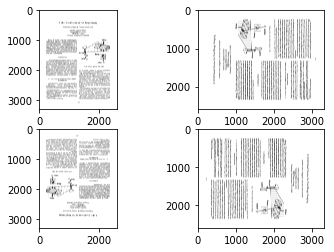

In [2]:
image = imread("testdata/W1P0.png")
for i, angle in enumerate([0, 90, 180, 270]):
    subplot(2, 2, i+1); imshow(ndi.rotate(image, angle))

In [3]:
figsize(10, 10)
import ocrorot
reload(ocrorot)

<module 'ocrorot' from '/usr/local/lib/python2.7/dist-packages/ocrorot/__init__.pyc'>

In [4]:
%%bash
model=rot-000003456-020897.pt
test -f $model || wget -nd https://storage.googleapis.com/tmb-models/$model

# Estimating Page Rotations

Old approach:
- detect connected components
- match connected components against dictionary

Problems:
- connected components hard to extract reliably
- what thresholds/parameters should we use?

# DL Page Rotation Estimation

- treat the problem like an object recognition problem
- (really: collection of objects)
- classify each input into one of four classes (0, 90, 180, 270)

# Patchwise Computations

- convolutional muti-resolution methods like this work best with fixed size inputs
- we're sampling 256x256 patches from the image and classifying them individually
- finally, aggregate the estimates across all patches

# Training Data Generation

Simplistic:
- scan pages at different orientations, label, etc.

Effective:
- start with a collection of pages that have been manually rotated into the right orientation
- generate all four rotations by in-memory rotations
- also: generate noisy and skewed versions to make classifier robust to noise and skew

In [5]:
# Loading the RotationEstimator Model
rot = ocrorot.RotationEstimator("rot-000003456-020897.pt")
rot.model

Sequential(
  (0): CheckSizes [(1, 128), (1, 512), (256, 256), (256, 256)]
  (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (11): ReLU()
  (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (13): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (15): ReLU()
  (16): Img2FlatSum
  (17): Linear(in_features=64, out_features=64, bias=

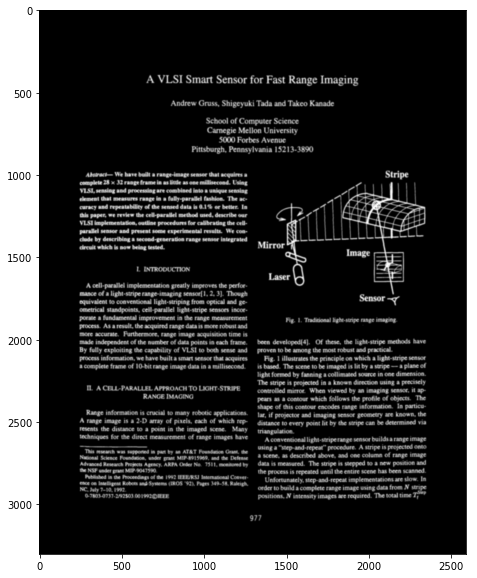

In [6]:
image = 1 - imread("testdata/W1P0.png")
imshow(image)

In [24]:
# load the model
rot = ocrorot.RotationEstimator("rot-000003456-020897.pt")

# rotation should be 0 degrees
rot.rotation(image)

0.0

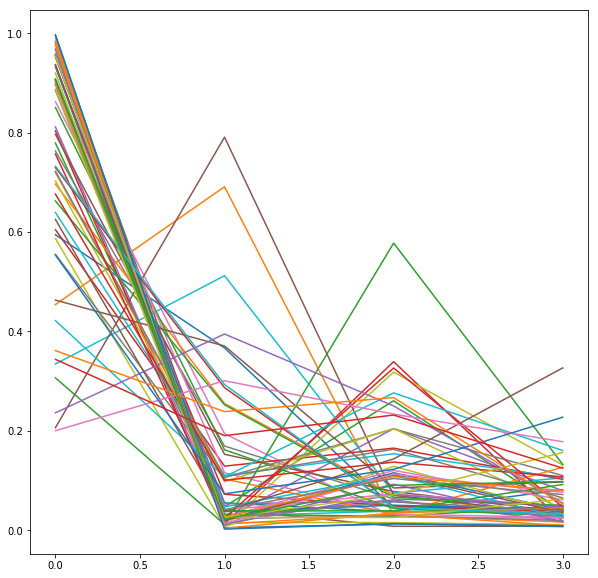

In [8]:
# Show the posterior probabilities for all the patches tested.
for p in rot.preds: plot(p)

# Posteriors?

- We're training a DL classifier using a one-hot encoding.
- The output values approximate posterior probabilities.
- $P(\hbox{class}\,|\,\hbox{data})$
- Multiple posterior probability estimates are commonly combined by averaging.

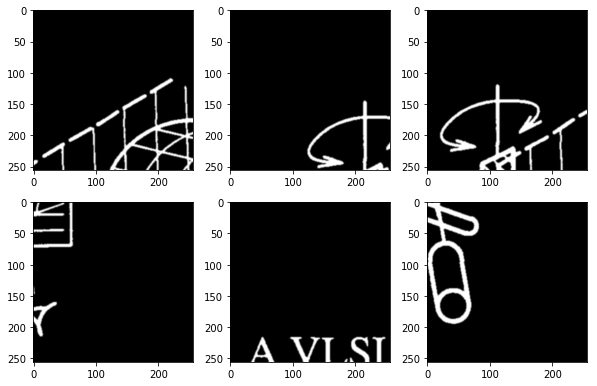

In [9]:
# Bad patches (could eventually identify via reject class)
for i, p in enumerate(rot.bad_patches()):
    if i>=9: break
    subplot(3, 3, i+1)
    imshow(p)

In [10]:
del rot

# Page Skew Detection

In [11]:
%%bash
model=logskew-000015808-000132.pt
test -f $model || wget --quiet -nd https://storage.googleapis.com/tmb-models/$model

In [12]:
sk = ocrorot.SkewEstimator("logskew-000015808-000132.pt")
sk.model

Sequential(
  (0): CheckSizes [(1, 128), (1, 512), (256, 256), (256, 256)]
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
  (3): ReLU()
  (4): Spectrum
  (5): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True)
  (7): ReLU()
  (8): Reshape((0, [1, 2, 3]))
  (9): Linear(in_features=262144, out_features=128, bias=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=30, bias=True)
  (13): Sigmoid()
  (14): CheckSizes [(1, 128), (30, 30)]
)

# Why a different model?

- Why not use the same mind of model as for large rotations?
- Because MaxPool-based models tend to be robust to rotations.
- Result: bad rotation estimates

# Why use the spectrum?

- Spectral techniques for skew detection work pretty well.
- Spectra are fast and easy to compute.
- We can backpropagate through the spectrum, allow feature extraction layers before.

Reasoning: "classically" we want:

feature extraction $\rightarrow$ spectrum $\rightarrow$ peak detection $\rightarrow$ angle

The model gives us that, just with training.

In [13]:
sk.skew(image)

-0.20000000000000018

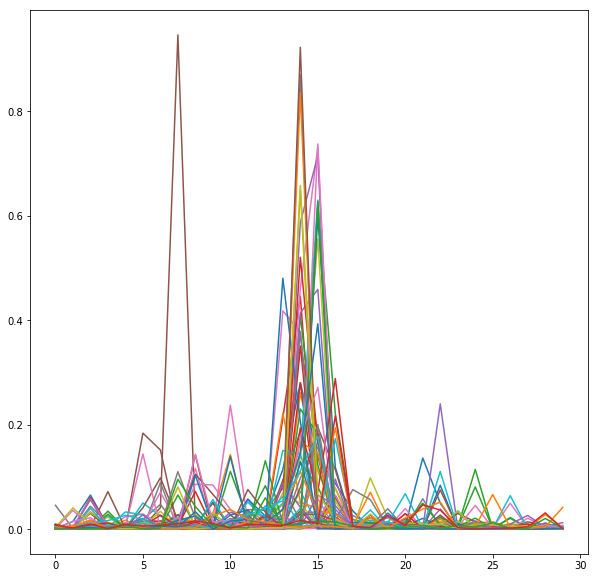

In [14]:
for p in sk.preds:
    plot(p)

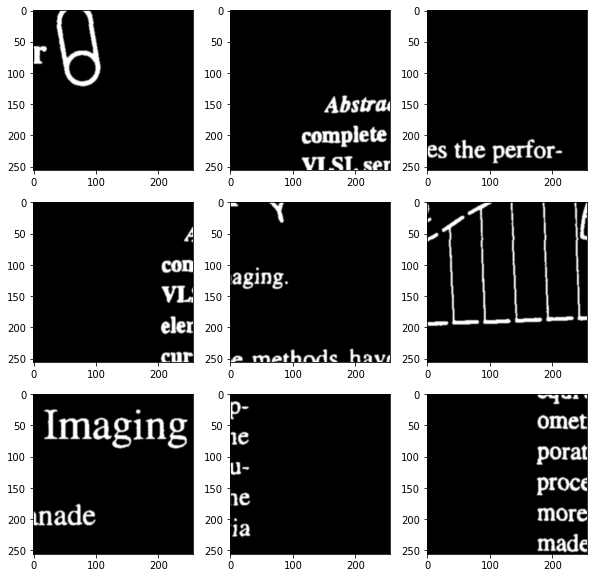

In [15]:
for i, p in enumerate(sk.bad_patches()):
    if i>=9: break
    subplot(3, 3, i+1)
    imshow(p)

# TRAINING

# Training

The rotation and skew models are trained on patches. To create the patch databases, we used already deskewed pages and extracted patches at different rotations, then used those for training.

In [16]:
# Training data as sharded tar file
!tar -ztvf /work/tmb/lpr-ocr/uw3-patches/uw3-patches-000.tgz | sed 6q

-rw-rw-rw- bigdata/bigdata  78 2018-04-11 21:30 A001BIN-0.params.json
-rw-rw-rw- bigdata/bigdata 3311 2018-04-11 21:30 A001BIN-0.patch.png
-rw-rw-rw- bigdata/bigdata   83 2018-04-11 21:30 A001BIN-1.params.json
-rw-rw-rw- bigdata/bigdata 9605 2018-04-11 21:30 A001BIN-1.patch.png
-rw-rw-rw- bigdata/bigdata   83 2018-04-11 21:30 A001BIN-2.params.json
-rw-rw-rw- bigdata/bigdata 6095 2018-04-11 21:30 A001BIN-2.patch.png
tar: write error


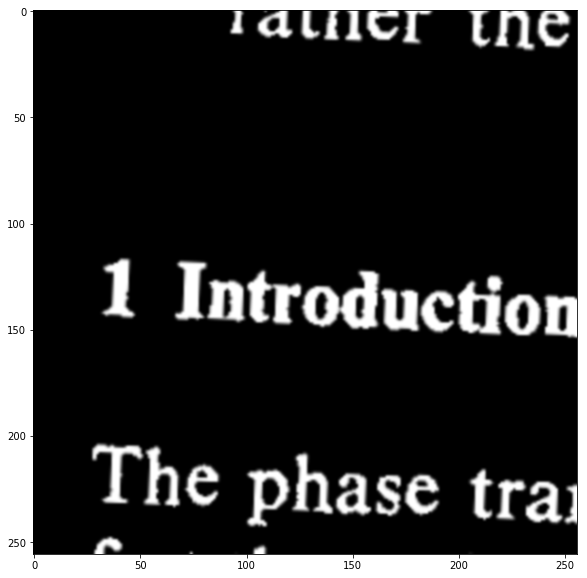

In [17]:
from dlinputs import gopen
data = gopen.sharditerator("/work/tmb/lpr-ocr/uw3-patches/uw3-patches-000.tgz")
data.next(); data.next(); sample = data.next()
imshow(sample["patch.png"])

In [23]:
print sample.keys()
print sample["params.json"]
print sample["__key__"]

['__source__', 'patch.png', 'params.json', '__key__']
{'alpha': 0.040806407654378804, 'scale': 0.9025840051825235, 'offset': [2021, 906]}
A001BIN-2


# Dataset Generation

This is literally the code used for generating the training data:

    data = gopen.sharditerator_once(args.input)
    sink = gopen.open_sink(args.output)
    for sample in data:
        page = sample["framed.png"]
        patches = get_patches(page)
        for i, (patch, params) in enumerate(patches[:16]):
            result = {
                "__key__": "{}-{}".format(sample["__key__"], i),
                "patch.png": patch,
                "params.json": params
            }
            sink.write(result)
            
This code is run in parallel over multiple shards, generating a lot of training data.

# Patch Generation

This is a typical data augmentation pipeline, here generating small rotations and scale variants of input patches.

    def get_patches(image, npatches=64, shape=(256, 256), ntrials=1024):
        patches = []
        h, w = image.shape
        for i in range(ntrials):
            if len(patches) >= npatches: break
            y, x = randint(0, h-1), randint(0, w-1)
            alpha = random.uniform(-ralpha*pi/180, ralpha*pi/180)
            scale = random.uniform(0.7, 1.4)
            patch = get_patch(image, (y, x), alpha=alpha, scale=scale, shape=shape)
            if mean(patch) < minmean: continue
            patches.append((patch, dict(offset=(y, x), alpha=alpha, scale=scale)))
        return patches

# Alternatives

- generate and augment patches on the fly (rather than offline)
  - uses less storage
  - slower and less reproducible
- don't train on binarized images but on degraded grayscale
  - works, but higher error rate
  - decide based on desired order
    - binarization $\rightarrow$ skew correction
    - skew correction $\rightarrow$ binarization
    
Q: when might one order be better than the other?

# Summary

- two important preprocessing steps: rotation/skew correction
- saw connection between DL model design and task
- posterior probability estimation and averaging
- example of simple data augmentation
- saw sharded tar files in action
- trained on synthetic data

# Next Steps

- want general document image dewarping from DL
  - projective transform correction
  - generaly ruled/warped surface correction
- speed up this step with better models (maybe global 2D LSTM)